**Imports**

In [1]:
import torch
import torch.nn as nn
from torch_geometric.datasets import Planetoid

**Dataset**

In [2]:

dataset = Planetoid(root="data", name="Cora")
data = dataset[0]

Processing...
C:\Users\ROG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\io\planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
C:\Users\ROG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\io\planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
C:\Users\ROG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\io\planetoid.py:107: VisibleDepre

In [3]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

**number of Nodes used for training**

In [4]:
len(data.train_mask[data.train_mask == True])

140

**Number of Nodes used for validation**

In [5]:
len(data.val_mask[data.val_mask == True])

500

**classes for node classification Task**

In [6]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

**Building Adjacency Matrix**

In [8]:
N = data.num_nodes 
edge_index =  data.edge_index

A = torch.zeros((N,N))
A[edge_index[0], edge_index[1]] = 1
A = A + A.T
A[A > 1] = 1
A[A == 1].shape

torch.Size([10556])

In [9]:
I = torch.eye(N) # Adding self loops
A_hat = A + I # adding self loops

D_hat = torch.diag(A_hat.sum(dim = 1))
D_hat_inv_sqrt = torch.linalg.inv(torch.sqrt(D_hat))

A_norm = D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt

**GCN Model**

In [10]:
class GCN(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim):
    super().__init__()
    self.W1 = torch.nn.Parameter(torch.randn(in_dim, hidden_dim))
    self.W2 = torch.nn.Parameter(torch.randn(hidden_dim, hidden_dim))
    self.W3 = torch.nn.Parameter(torch.randn(hidden_dim, out_dim))

  def forward(self, A_norm , X):
    H = torch.relu(A_norm @ X @ self.W1) # 1st Aggreation and projection
    H = A_norm @ H @ self.W2 # 2nd Aggregation & projection
    H = A_norm @ H @ self.W3
    return H

**Adjacency matrix Dimension**

In [13]:
A_norm.shape

torch.Size([2708, 2708])

**Train Loop**

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model = GCN(in_dim = data.x.size(1),hidden_dim = 6,out_dim = dataset.num_classes).to(device)

X = data.x.to(device)
A_norm = A_norm.to(device)
labels = data.y.to(device)
train_mask = data.train_mask.to(device)
test_mask = data.test_mask.to(device)

epochs = 3000
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 5e-2)
loss_fn = nn.CrossEntropyLoss()

losses = []

for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()

  out = model(A_norm, X)
  loss = loss_fn(out[train_mask], labels[train_mask])
  losses.append(loss.item())
  loss.backward()
  optimizer.step()

  if epoch % 20 == 0:
    pred = out.argmax(dim=1)
    acc = (pred[train_mask] == labels[train_mask]).float().mean()
    print(f"Epoch {epoch} | Loss {loss:.4f} | Train Acc {acc:.3f}")

Epoch 0 | Loss 9.7543 | Train Acc 0.100
Epoch 20 | Loss 8.1495 | Train Acc 0.114
Epoch 40 | Loss 6.9204 | Train Acc 0.107
Epoch 60 | Loss 5.9765 | Train Acc 0.100
Epoch 80 | Loss 5.2280 | Train Acc 0.100
Epoch 100 | Loss 4.6147 | Train Acc 0.114
Epoch 120 | Loss 4.0976 | Train Acc 0.143
Epoch 140 | Loss 3.6559 | Train Acc 0.143
Epoch 160 | Loss 3.2835 | Train Acc 0.143
Epoch 180 | Loss 2.9833 | Train Acc 0.164
Epoch 200 | Loss 2.7481 | Train Acc 0.179
Epoch 220 | Loss 2.5635 | Train Acc 0.193
Epoch 240 | Loss 2.4115 | Train Acc 0.229
Epoch 260 | Loss 2.2808 | Train Acc 0.243
Epoch 280 | Loss 2.1682 | Train Acc 0.257
Epoch 300 | Loss 2.0706 | Train Acc 0.271
Epoch 320 | Loss 1.9854 | Train Acc 0.286
Epoch 340 | Loss 1.9104 | Train Acc 0.293
Epoch 360 | Loss 1.8441 | Train Acc 0.307
Epoch 380 | Loss 1.7844 | Train Acc 0.329
Epoch 400 | Loss 1.7308 | Train Acc 0.350
Epoch 420 | Loss 1.6820 | Train Acc 0.364
Epoch 440 | Loss 1.6373 | Train Acc 0.379
Epoch 460 | Loss 1.5960 | Train Acc 0.38

**Eval loop**

In [22]:
model.eval()
with torch.no_grad():
    out = model(A_norm, X)
    pred = out.argmax(dim=1)
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
    print("Test Accuracy:", test_acc.item())


Test Accuracy: 0.7450000643730164


In [23]:
torch.save(model.state_dict(), "gcn_cora.pth")

**Loss Vs epoch curve**

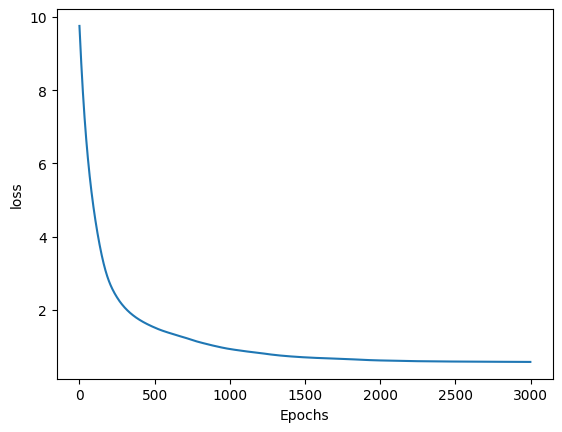

In [25]:
import matplotlib.pyplot as plt
import numpy as np

epc = np.arange(epochs)

plt.plot(epc, losses)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

### Comparing this result with GCN Conv from

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [28]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN_lib(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super().__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, out_channels)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.conv3(x, edge_index)
    return x

In [27]:
data = data.to(device)
def train(model, X, data, optimizer, labels, train_mask):
  model.train()
  optimizer.zero_grad()

  out = model(X, data.edge_index)
  loss = F.cross_entropy(out[train_mask], labels[train_mask])

  loss.backward()
  optimizer.step()
  return loss.item()

def test(model, X, data, labels, test_mask):
  model.eval()
  out = model(X, data.edge_index)
  pred = out.argmax(dim=1)

  correct = (pred[test_mask] == labels[data.test_mask]).sum()
  acc = int(correct) / int(data.test_mask.sum())
  return acc
device

device(type='cuda')

In [36]:
labels = data.y.to(device)
train_mask = data.train_mask.to(device)
test_mask = data.test_mask.to(device)

model = GCN_lib(in_channels = data.x.size(1),hidden_channels = 16, out_channels = dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay = 5e-4)

losses_ = []

epochs = 200
for epoch in range(epochs):
  loss = train(model, data.x, data, optimizer, labels, train_mask)
  losses_.append(loss)
acc = test(model, data.x, data, labels, test_mask)

**Test Accuracy for GCNConv**

In [37]:
acc

0.799

In [39]:
losses_[10],losses_[100] # Loss decreases Rapidly

(0.8440542221069336, 0.006139061413705349)

**Loss Curve GCNConv**

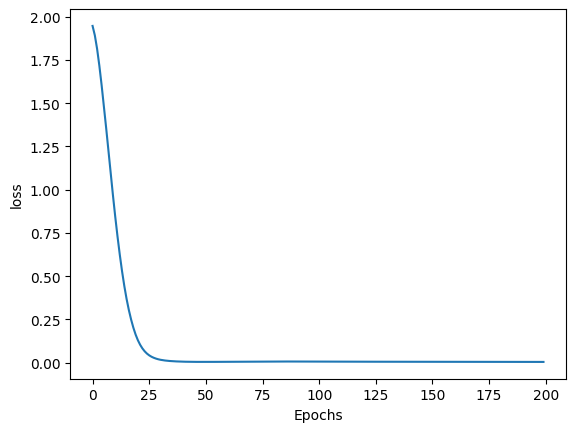

In [40]:
import matplotlib.pyplot as plt
import numpy as np

epc = np.arange(epochs)

plt.plot(epc, losses_)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()